In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [4]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

## Let's use CoNLL 2002 data to build a NER system

CoNLL2002 corpus is available in NLTK. We use Spanish data.

In [5]:
nltk.corpus.conll2002.fileids()

['esp.testa', 'esp.testb', 'esp.train', 'ned.testa', 'ned.testb', 'ned.train']

In [6]:
%%time
train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

CPU times: total: 5.72 s
Wall time: 5.93 s


In [7]:
train_sents[0]

[('Melbourne', 'NP', 'B-LOC'),
 ('(', 'Fpa', 'O'),
 ('Australia', 'NP', 'B-LOC'),
 (')', 'Fpt', 'O'),
 (',', 'Fc', 'O'),
 ('25', 'Z', 'O'),
 ('may', 'NC', 'O'),
 ('(', 'Fpa', 'O'),
 ('EFE', 'NC', 'B-ORG'),
 (')', 'Fpt', 'O'),
 ('.', 'Fp', 'O')]

## Features

Next, define some features. In this example we use word identity, word suffix, word shape and word POS tag; also, some information from nearby words is used. 

This makes a simple baseline, but you certainly can add and remove some features to get (much?) better results - experiment with it.

sklearn-crfsuite (and python-crfsuite) supports several feature formats; here we use feature dicts.

In [8]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],        
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

This is what word2features extracts:

In [9]:
sent2features(train_sents[0])[0]

{'bias': 1.0,
 'word.lower()': 'melbourne',
 'word[-3:]': 'rne',
 'word[-2:]': 'ne',
 'word.isupper()': False,
 'word.istitle()': True,
 'word.isdigit()': False,
 'postag': 'NP',
 'postag[:2]': 'NP',
 'BOS': True,
 '+1:word.lower()': '(',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'Fpa',
 '+1:postag[:2]': 'Fp'}

Extract features from the data:

In [10]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: total: 1.17 s
Wall time: 1.17 s


## Training

To see all possible CRF parameters check its docstring. Here we are useing L-BFGS training algorithm (it is default) with Elastic Net (L1 + L2) regularization.

In [11]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: total: 34.2 s
Wall time: 34.3 s


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

## Evaluation

There is much more O entities in data set, but we're more interested in other entities. To account for this we'll use averaged F1 score computed for all labels except for O. ``sklearn-crfsuite.metrics`` package provides some useful metrics for sequence classification task, including this one.

In [12]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']

In [13]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.7964686316443963

Inspect per-class results in more detail:

In [14]:
# group B and I results
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.810     0.784     0.797      1084
       I-LOC      0.690     0.637     0.662       325
      B-MISC      0.731     0.569     0.640       339
      I-MISC      0.699     0.589     0.639       557
       B-ORG      0.807     0.832     0.820      1400
       I-ORG      0.852     0.786     0.818      1104
       B-PER      0.850     0.884     0.867       735
       I-PER      0.893     0.943     0.917       634

   micro avg      0.813     0.787     0.799      6178
   macro avg      0.791     0.753     0.770      6178
weighted avg      0.809     0.787     0.796      6178



## Hyperparameter Optimization

To improve quality try to select regularization parameters using randomized search and 3-fold cross-validation.

I takes quite a lot of CPU time and RAM (we're fitting a model ``50 * 3 = 150`` times), so grab a tea and be patient, or reduce n_iter in RandomizedSearchCV, or fit model only on a subset of training data.

In [15]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: total: 5min 48s
Wall time: 27min 24s


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DC4BACA190>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001DC4BACA220>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-LOC', 'B-ORG', 'B-PER', 'I-PER', 'B-MISC', 'I-ORG', 'I-LOC', 'I-MISC']),
                   verbose=1)

Best result:

In [16]:
# crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.24572938857430263, 'c2': 0.011806642595519884}
best CV score: 0.7494576333669977
model size: 1.04M


In [48]:
params = rs.cv_results_['params']

In [51]:
scores = rs.cv_results_['mean_test_score']

### Check parameter space

A chart which shows which ``c1`` and ``c2`` values have RandomizedSearchCV checked. Red color means better results, blue means worse.

Dark blue => 0.7099, dark red => 0.7495


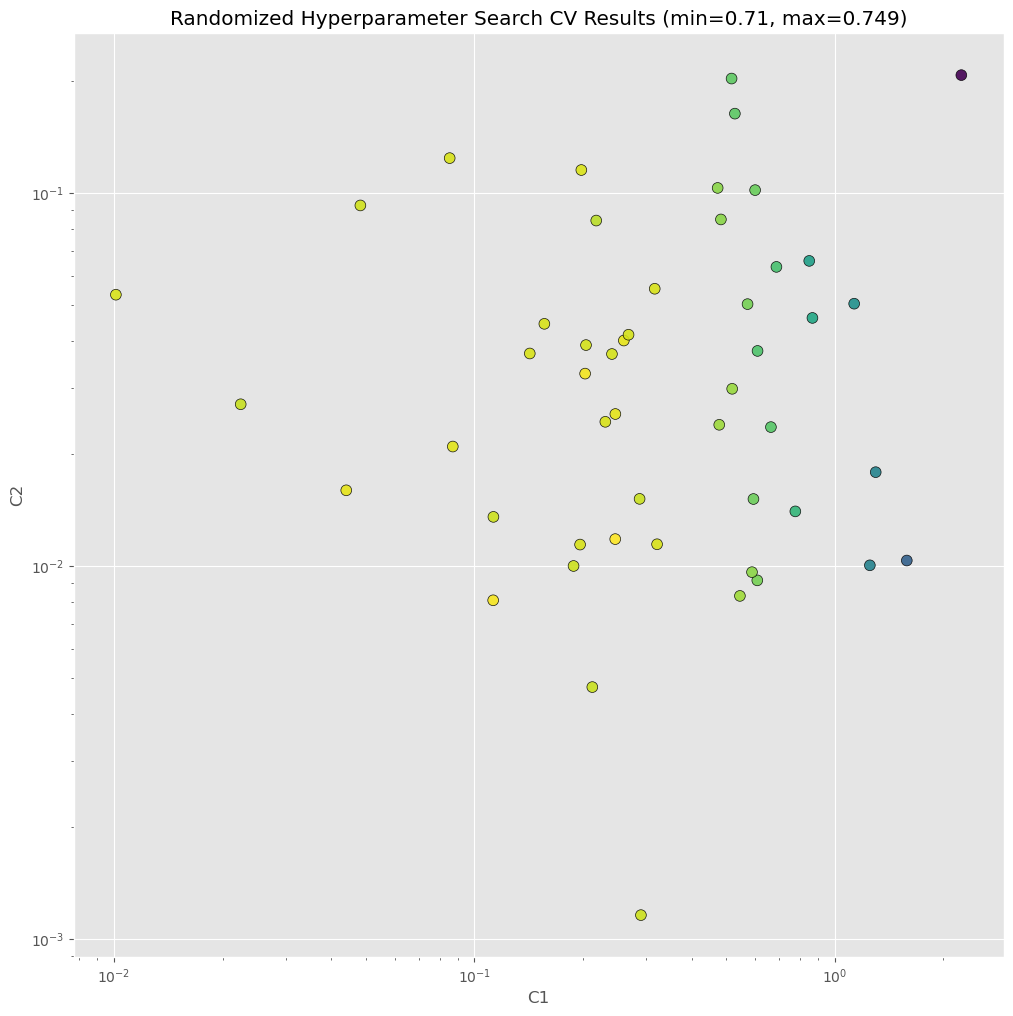

In [53]:
_x = [params[s]['c1'] for s in range(len(params))]
_y = [params[s]['c2'] for s in range(len(params))]
_c = [scores[s] for s in range(len(params))]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

## Check best estimator on our test data

As you can see, quality is improved.

In [55]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-LOC      0.795     0.781     0.788      1084
       I-LOC      0.654     0.634     0.644       325
      B-MISC      0.708     0.566     0.630       339
      I-MISC      0.690     0.607     0.646       557
       B-ORG      0.811     0.826     0.819      1400
       I-ORG      0.850     0.778     0.812      1104
       B-PER      0.846     0.880     0.863       735
       I-PER      0.896     0.940     0.918       634

   micro avg      0.806     0.784     0.795      6178
   macro avg      0.781     0.752     0.765      6178
weighted avg      0.803     0.784     0.792      6178



## Let's check what classifier learned

In [56]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-ORG  -> I-ORG   7.304438
I-ORG  -> I-ORG   7.092698
I-MISC -> I-MISC  6.587897
B-MISC -> I-MISC  6.564121
B-PER  -> I-PER   5.922546
B-LOC  -> I-LOC   5.303015
I-LOC  -> I-LOC   4.731320
I-PER  -> I-PER   4.496641
O      -> O       4.013605
O      -> B-ORG   2.824474
O      -> B-PER   2.354473
O      -> B-LOC   1.885858
O      -> B-MISC  1.664491
B-ORG  -> O       0.326761
I-PER  -> B-LOC   0.295077
B-LOC  -> B-LOC   0.047411
B-MISC -> B-ORG   0.026491
B-ORG  -> B-LOC   -0.195100
B-LOC  -> B-PER   -0.212288
B-MISC -> B-LOC   -0.302835

Top unlikely transitions:
I-MISC -> I-ORG   -2.959025
I-MISC -> B-LOC   -3.053332
I-LOC  -> I-PER   -3.058101
B-LOC  -> I-PER   -3.063245
I-ORG  -> B-MISC  -3.174497
I-PER  -> I-LOC   -3.183930
B-PER  -> B-MISC  -3.202538
I-PER  -> B-ORG   -3.207621
I-MISC -> I-PER   -3.212787
I-ORG  -> I-PER   -3.389683
I-ORG  -> I-LOC   -3.471886
B-ORG  -> B-MISC  -3.513164
B-PER  -> B-PER   -3.736224
I-PER  -> B-MISC  -3.770856
I-MISC -> I-LO

We can see that, for example, it is very likely that the beginning of an organization name (B-ORG) will be followed by a token inside organization name (I-ORG), but transitions to I-ORG from tokens with other labels are penalized.

Check the state features:

In [57]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
14.458280 B-ORG    word.lower():efe-cantabria
12.528058 B-ORG    word.lower():psoe-progresistas
10.795584 B-ORG    word[-2:]:-e
9.123071 B-ORG    word.lower():petrobras
9.050003 B-ORG    word.lower():coag-extremadura
9.024833 I-ORG    -1:word.lower():l
8.501186 I-ORG    -1:word.lower():rasd
7.791501 B-LOC    +1:word.lower():finalizaron
7.620970 B-MISC   word.lower():cc2305001730
7.549062 I-ORG    -1:word.lower():ag
7.156141 B-PER    word.lower():orduña
7.100119 B-ORG    -1:word.lower():distancia
7.037979 B-ORG    word.lower():eu-ecologista
6.859118 B-MISC   word.lower():diversia
6.726006 B-ORG    +1:word.lower():plasencia
6.700131 B-MISC   word.lower():vaciamadrid
6.698073 B-ORG    word.lower():xfera
6.663866 B-ORG    word[-2:]:SF
6.546223 B-LOC    -1:word.lower():cantabria
6.441534 B-LOC    -1:word.lower():celebrarán
6.357275 B-PER    word.lower():salva
6.297942 B-ORG    -1:word.lower():sociolaboral
6.215770 I-LOC    -1:word.lower():calle
6.182947 B-ORG    word.lower():e



Some observations:

   * **9.385823 B-ORG word.lower():psoe-progresistas** - the model remembered names of some entities - maybe it is overfit, or maybe our features are not adequate, or maybe remembering is indeed helpful;
   * **4.636151 I-LOC -1:word.lower():calle:** "calle" is a street in Spanish; model learns that if a previous word was "calle" then the token is likely a part of location;
   * **-5.632036 O word.isupper()**, **-8.215073 O word.istitle()** : UPPERCASED or TitleCased words are likely entities of some kind;
   * **-2.097561 O postag:NP** - proper nouns (NP is a proper noun in the Spanish tagset) are often entities.

What to do next

    * Load 'testa' Spanish data.
    * Use it to develop better features and to find best model parameters.
    * Apply the model to 'testb' data again.

The model in this notebook is just a starting point; you certainly can do better!

